# Simulation for normal market condition

### Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from model import SimulationModel
from statsmodels.tsa.stattools import acf
from scipy.stats import kurtosis

cwd = os.path.join('game_without_spoofing', 'data')

## Run Model

### Model Prams

In [47]:
# number of agents
num_ZI = 100  # number of ZI agents
num_F = 200  # number of fundamentalists agents
num_C = 200  # number of chartists agents

# agent parameters

ZI_params = {'order_price_lambda': 0.8, 'order_price_sig': 0.25, 'order_size_multiplier': 1}
F_params = {'a_lower': 0.1, 'a_upper': 0.15, 'h_sig_lower': 1.0, 'h_sig_upper': 2.0, 'order_duration': 15, 'order_life': 5, 'order_size_sigma': 2.5, 'order_size_lower': 1.0, 'order_size_upper': 10.0, 'order_price_sigma': 0.25, 'order_price_lambda': 0.8, 'order_size_gamma': 3.0}
C_params = {'c_lower': 0.0025, 'c_upper': 0.01, 'L_lower': 3, 'L_upper': 10, 'h_sig_lower':0.1, 'h_sig_upper': 0.2, 'order_duration': 5, 'order_life': 5, 'order_size_sigma': 2.5, 'order_size_lower': 1.0, 'order_size_upper': 10.0, 'order_price_sigma': 0.25, 'order_price_lambda': 0.8, 'order_size_gamma': 3.0, 'd_lower': 0.08, 'd_upper': 0.1, 'Tsp_lower': 1.4, 'Tsp_upper': 2.0}

num_sim_times = 2000

### Run Model

In [48]:
model = SimulationModel(num_ZI=num_ZI, 
                        num_F=num_F,
                        num_C=num_C,
                        ZI_params=ZI_params,
                        F_params=F_params,
                        C_params=C_params)

for _ in tqdm(range(num_sim_times)):
    model.step()

# save data
np.save(os.path.join(cwd, 'price_series.npy'), np.array(model.price_series))  # price series
np.save(os.path.join(cwd, 'return_series.npy'), np.array(model.get_return_series()))  # return series
np.save(os.path.join(cwd, 'num_matches.npy'), np.array(model.num_matching_series))  # number of matches
np.save(os.path.join(cwd, 'spread_series.npy'), np.array(model.spread_series))  # spread series
np.save(os.path.join(cwd, 'bid_volume.npy'), np.array(model.bid_volume))  # bid volume
np.save(os.path.join(cwd, 'ask_volume.npy'), np.array(model.ask_volume))  # ask volume
np.save(os.path.join(cwd, 'f_actions.npy'), np.array(model.agent_groups[1].agents_traded_action_record))
np.save(os.path.join(cwd, 'c_actions.npy'), np.array(model.agent_groups[2].agents_traded_action_record))
np.save(os.path.join(cwd, 'f_h.npy'), np.array(model.heuristic_avg[1]))  # fundamentalist heuristic
np.save(os.path.join(cwd, 'c_h.npy'), np.array(model.heuristic_avg[2]))  # chartist heuristic


100%|██████████| 2000/2000 [00:33<00:00, 60.08it/s]


## General Obs

In [2]:
# load data
price_series = np.load(os.path.join(cwd, 'price_series.npy'))
return_series = np.load(os.path.join(cwd, 'return_series.npy'))
num_matching_series = np.load(os.path.join(cwd, 'num_matches.npy'))
spread_series = np.load(os.path.join(cwd, 'spread_series.npy'))
bid_vol_series = np.load(os.path.join(cwd, 'bid_volume.npy'))
ask_vol_series = np.load(os.path.join(cwd, 'ask_volume.npy'))
f_h_series = np.load(os.path.join(cwd, 'f_h.npy'))
c_h_series = np.load(os.path.join(cwd, 'c_h.npy'))
f_actions = np.load(os.path.join(cwd, 'f_actions.npy'))
c_actions = np.load(os.path.join(cwd, 'c_actions.npy'))

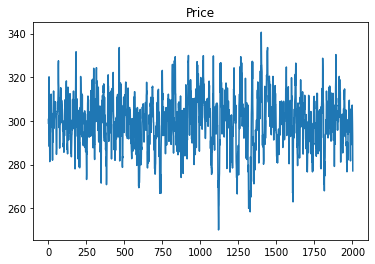

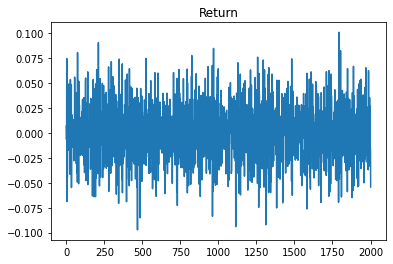

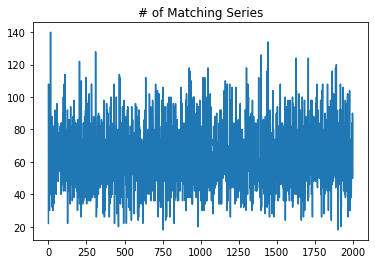

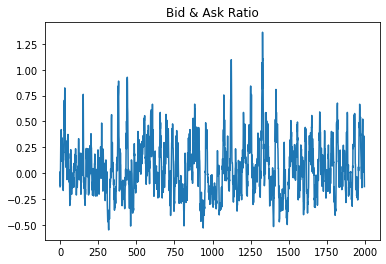

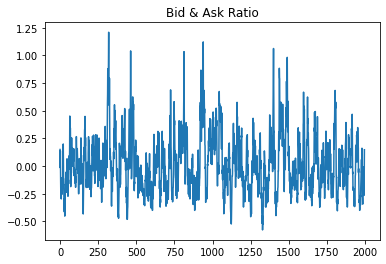

Average Price:
299.58122066899654
Average Return:
0.0003018624442246342
Average num of Matching:
63.904
Average Spread:
3.2603550000000006
3.6929925401837953


In [50]:
plt.plot(price_series)
plt.title('Price')
plt.show()
plt.plot(return_series)
plt.title('Return')
plt.show()
plt.title('# of Matching Series')
plt.plot(num_matching_series)
plt.show()
plt.plot(np.array(bid_vol_series[3:]) / np.array(ask_vol_series[3:])-1)
plt.title('Bid & Ask Ratio')
plt.show()
plt.plot(np.array(ask_vol_series[3:]) / np.array(bid_vol_series[3:])-1)
plt.title('Bid & Ask Ratio')
plt.show()
print('Average Price:')
print(np.mean(price_series))
print('Average Return:')
print(np.mean(return_series))
print('Average num of Matching:')
print(np.mean(num_matching_series))
print('Average Spread:')
print(np.mean(spread_series))
print(kurtosis(return_series, fisher=False))

### Market Dynamics

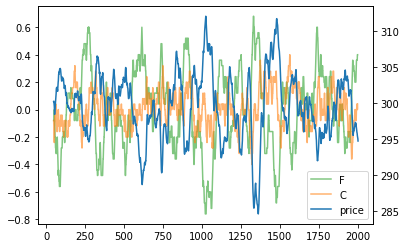

In [53]:
def heuristic_tradingActions(herustics):
    result = []
    for i in herustics:
        if i > 0:
            result.append(1)
        else:
            result.append(-1)
    return np.array(result)

trading_actions_f = heuristic_tradingActions(f_h_series)
trading_actions_movingAvg_f = pd.Series(trading_actions_f).rolling(window=50).mean()

trading_actions_c = heuristic_tradingActions(c_h_series)
trading_actions_movingAvg_C = pd.Series(trading_actions_c).rolling(window=50).mean()

model_price_movingAvg = pd.Series(price_series).rolling(window=50).mean()

fig, ax1 = plt.subplots(1, 1)
x = np.array(range(num_sim_times))
ax2 = ax1.twinx()
ln1 = ax1.plot(trading_actions_movingAvg_f, label='F', alpha=0.6, color='#2ca02c')
ln2 = ax1.plot(trading_actions_movingAvg_C, label='C', alpha=0.6, color='#ff7f0e')
ln3 = ax2.plot(model_price_movingAvg, color='#1f77b4', label='price')
leg = ln1 + ln2 + ln3
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs)
# plt.savefig('result_plots/market_dynamic.png', dpi=2000)
plt.show()